<a href="https://colab.research.google.com/github/wingated/cs473/blob/main/labs/cs473_lab_week_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><p><b>After clicking the "Open in Colab" link, copy the notebook to your own Google Drive before getting started, or it will not save your work</b></p>

# BYU CS 473 Lab Week 10

## Introduction:

In this lab, you will be implementing a Relevance Vector Machine Classifier and analyzing it relative to other Support Vector Machine methods. As discussed in your reading (section 17.4), RVMs are probabilistic, sparse models that use kernels and regularization to enforce sparsity on the subset of training examples used by the classifier.

You will be implementing an RVM using a few different kernels, and comparing the resulting fit of using each kernel to the provided data. You will also be looking at the efficiency of this method relative to other SVMs. In the end, you will be replicating this graph from the textbook.

![finished figure](https://raw.githubusercontent.com/wingated/cs473/main/labs/images/lab_week_10_image1.png)


---
## Grading standards   

Your notebook will be graded on the following:

* 50% Correct implementation of RVM
* 20% Correct use of cross-validation to pick C
* 30% Analysis of different methods
---

#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import RBFSampler

from sklearn.datasets import make_moons


### Implementing Relevance Vector Machine Classifier

You will be implementing a Relevance Vector Machine Classifier (RVM) to try and separate the following dataset:

![Moons Data](https://raw.githubusercontent.com/wingated/cs473/main/labs/images/lab_week_10_image2.png)

You will be implementing at least 3 types of kernels within the RVC (some options are listed in section 17.1.2). For your first kernel, you must use an RBF kernel with a bandwidth parameter of 0.3. The equation for the RBF kernel is equation 17.3 on page 568 of the textbook. The other two kernels are up to you, but think hard about which kernels might perform best on this particular dataset (is the data linearly separable?)

![RBF Equation](https://raw.githubusercontent.com/wingated/cs473/main/labs/images/lab_week_10_image3.png)

The algorithm for implementing RVM uses an approach similar to expectation-maximization (which you coded up earlier in the semester). The E-step has been provided for you in the _map_estimate() function. Look over the code and make sure you know what's going on. You will be implementing the M-step (fit). In this function, you will calculate the kernel using your data X, then:

For each iteration, you will:

1. Calculate the mean and covariance using self._map_estimate() and your kernel
2. Update alpha parameter to promote sparsity using:

    $alpha(new) = gamma/mean^{2}$ where $gamma = 1 - alpha(old)*covariance$
3. When updating alpha, clip it between the values (0, 1e10) to maintain stability

After it has either converged (the new alpha is equal to the old alpha) or it has reached the max number of iterations, the provided code will set your relevance vectors and the final mean/covariance.


In [2]:
class RVC:
    def __init__(self, kernel='rbf', alpha=1.0):
        self.threshold_alpha = 1e8
        self.alpha = alpha
        self.iter_max = 100
        self.relevance_vectors_ = []
        self.kernel = kernel

    # Kernel matrix
    def kernel_mat(self, X, Y):
        '''
        Computes the kernel matrix between two inputs X and Y
        Returns an NxN matrix where N is the number of samples in X and Y
        '''
        # Your code here
        if self.kernel == 'rbf':
            sigma = 0.3
            X_norm = np.sum(X**2, axis=1).reshape(-1, 1)
            Y_norm = np.sum(Y**2, axis=1).reshape(1, -1)
            K = np.exp(-(X_norm + Y_norm - 2 * X @ Y.T) / (2 * sigma**2))
            return K

        elif self.kernel == 'linear':
          return X @ Y.T

        elif self.kernel == 'poly':
          return (X @ Y.T + 1) ** 2

    '''
    For the current fixed values of alpha, the most probable
    weights are found by maximizing w over p(w/t,alpha)
    using the Laplace approximation of finding a hessian.
    (E step)
    Phi = your kernel matrix
    w = mean of p(w/t,alpha)
    cov = negative hessian of p(w/t,alpha)
    '''
    def _map_estimate(self, Phi, target, w, n_iter=10):
        for _ in range(n_iter):
            y = self.sigmoid(Phi @ w)
            g = Phi.T @ (y - target) + self.alpha * w
            H = (Phi.T * y * (1 - y)) @ Phi + np.diag(self.alpha)  # negated Hessian of p(w/t,alpha)
            w -= np.linalg.lstsq(H, g, rcond=None)[0]  # works even for singular matrices.
        covariance = np.linalg.pinv(H)  # inverse of H is the covariance of the gaussian approximation.
        return w, covariance


    '''
    Fitting of input-target pairs works by
    iteratively finding the most probable weights(done by _map_estimate method)
    and optimizing the hyperparameters(alpha) until there is no
    siginificant change in alpha.

    (M step)
    Optimizing alpha:
        For the given targets and current variance(sigma^2) alpha is optimized over p(t/alpha,variance)
        It is done by Mackay approach(ARD).
        alpha(new) = gamma/mean^2
        where gamma = 1 - alpha(old)*covariance.

    After finding the hyperparameters(alpha),
    the samples which have alpha less than the threshold(hence weight >> 0)
    are choosen as relevant vectors.

    Now predicted y = sign(phi(X) @ mean) (mean contains the optimal weights)
    '''
    def fit(self, X, y):
      N = len(y)
      self.alpha = np.zeros(N) + self.alpha
      mean = np.zeros(N)

      Phi = self.kernel_mat(X, X)

      for iteration in range(self.iter_max):
          # E-step: compute mean and covariance
          mean, covariance = self._map_estimate(Phi, y, mean)

          # M-step: update alpha
          gamma = 1 - self.alpha * np.diag(covariance)  # gamma_i = 1 - alpha_i * covariance_ii
          new_alpha = gamma / (mean**2 + 1e-32)  # add small epsilon to avoid div by zero
          new_alpha = np.clip(new_alpha, 0, 1e10)  # maintain stability

          # check convergence
          if np.allclose(new_alpha, self.alpha, rtol=1e-4):
              break

          self.alpha = new_alpha

      # Keep only relevance vectors
      ret_alpha = self.alpha < self.threshold_alpha
      self.relevance_vectors_ = X[ret_alpha]
      self.y = y[ret_alpha]
      self.alpha = self.alpha[ret_alpha]

      # Recompute final Phi, mean, covariance with relevance vectors
      Phi = self.kernel_mat(self.relevance_vectors_, self.relevance_vectors_)
      mean = mean[ret_alpha]
      self.mean, self.covariance = self._map_estimate(Phi, self.y, mean, 100)


    def predict(self, X):
        phi = self.kernel_mat(X, self.relevance_vectors_)
        return (phi @ self.mean > 0).astype(int)

    def predict_proba(self, X):
        phi = self.kernel_mat(X, self.relevance_vectors_)
        mu_a = phi @ self.mean
        var_a = np.sum(phi @ self.covariance * phi, axis=1)
        return 1 - self.sigmoid(mu_a / np.sqrt(1 + np.pi * var_a / 8))

    def sigmoid(self, a):
        return np.tanh(a * 0.5) * 0.5 + 0.5


### Compare Kernels

Below is some code to plot the data with the decision boundaries of your RVC fit to the data. Plot each of your RVC implementations (with the three different kernels) and below, discuss how each did at separating the datapoints.

In [3]:
N = 200
X, y = make_moons(n_samples=N, noise=0.3, random_state=10)

h = 0.05  # step size in the mesh

# Mesh to use in the boundary plotting.
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

def plot_scatters(X, y):
    for class_value in range(2):
        # get row indexes for samples with this class
        row_ix = np.where(y == class_value)
        # creating scatter of these samples
        plt.scatter(X[row_ix, 0], X[row_ix, 1], marker="X", s=30)


def plot_SVs(SV):
    plt.scatter(SV[:, 0], SV[:, 1], s=100, facecolor="none", edgecolor="green")


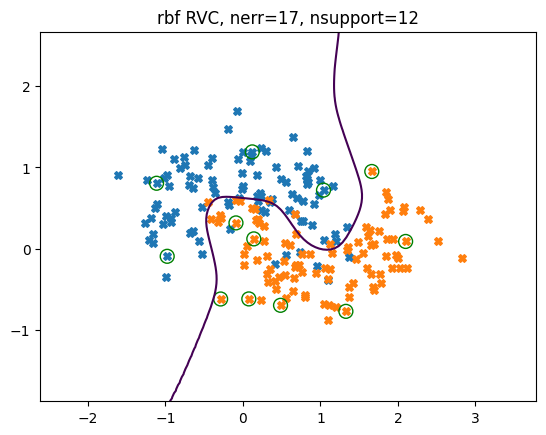

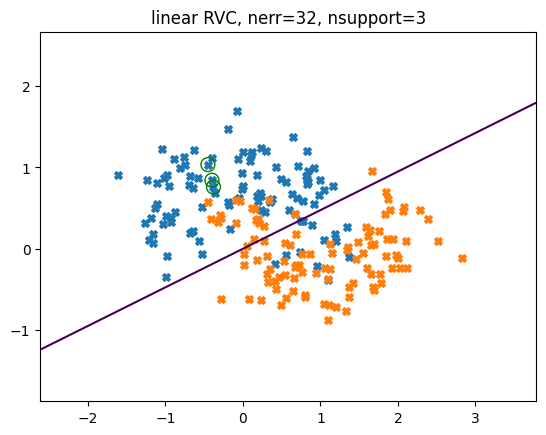

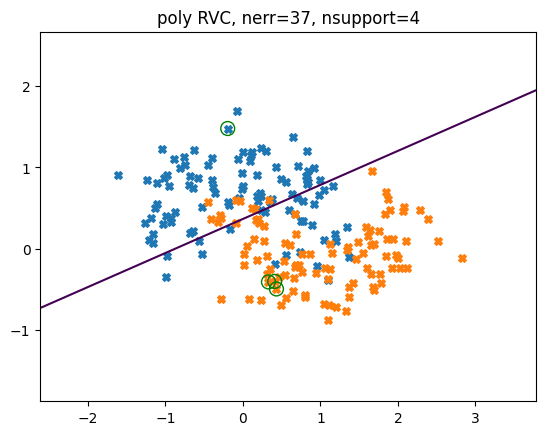

In [4]:
levels = [0.5]

kernel_names = ['rbf', 'linear', 'poly']

for kernel in kernel_names:
    clf = RVC(kernel=kernel)
    clf.fit(X, y)
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, levels)
    plot_scatters(X, y)
    SV = clf.relevance_vectors_
    plot_SVs(SV)
    nsupport = SV.shape[0]
    nerr = np.sum(y != clf.predict(X))
    plt.title(f"{kernel} RVC, nerr={nerr}, nsupport={nsupport}")
    plt.show()
    print()

RBF did the best by far. Linear successfully separated the main bodies, but there's a significant amount of crossover. Poly did about as well as linear.

### Choosing the regularizer C

In section 17.3.8, the book discusses the regularizing term C. C is a necessary parameter in SVM (but not in RVM) and is typically chosen by using cross-validation. Use cross-validation over values of C in the range $2^{-5}$ to $2^{5}$. You should calculate the mean cross validation score for each value of c using an SVC and X, y data from earlier. Then choose the c value with the highest mean score.

(Hint: you may use sklearn.model_selection.cross_val_score and sklearn.svm.SVC. For your SVC, use an rbf kernel and a gamma value of 0.3)


In [5]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

C_values = 2.0 ** np.arange(-5, 6)  # 2.0 instead of 2

mean_scores = []

for C in C_values:
    clf = SVC(kernel='rbf', gamma=0.3, C=C)
    scores = cross_val_score(clf, X, y, cv=5)  # 5-fold CV
    mean_scores.append(scores.mean())

best_idx = np.argmax(mean_scores)
c = C_values[best_idx]

print(f"Best C: {c}, Mean CV score: {mean_scores[best_idx]:.4f}")

Best C: 16.0, Mean CV score: 0.8700


### Analysis of Sparsity

You will now use the value of c you calculated above and compare the fits of four different SVM methods, including the RVC model you implemented. The code below will plot the fit of each method. Run the cells below, then answer the questions below.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

classifiers = {
    "logregL2": OneVsRestClassifier(LogisticRegression(C=c, penalty="l2", solver="saga", max_iter=10000)),
    "logregL1": OneVsRestClassifier(LogisticRegression(C=c, penalty="l1", solver="saga", max_iter=10000)),
    "RVM": RVC(kernel='rbf'),
    "SVM": SVC(kernel="rbf", gamma=0.3, C=c, probability=True),
}


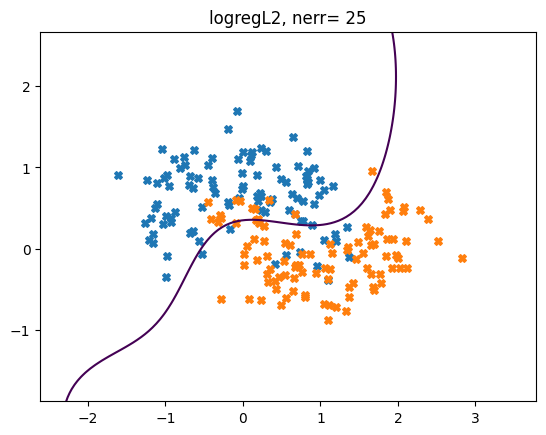

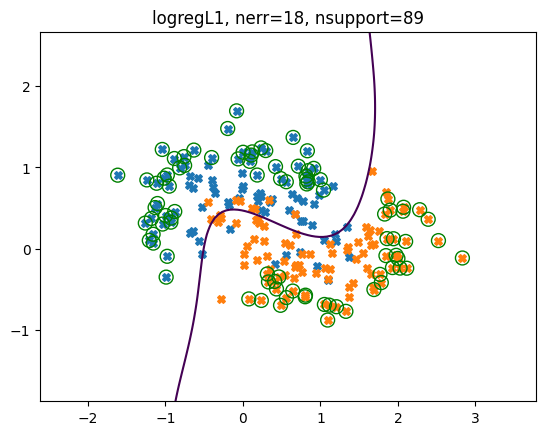

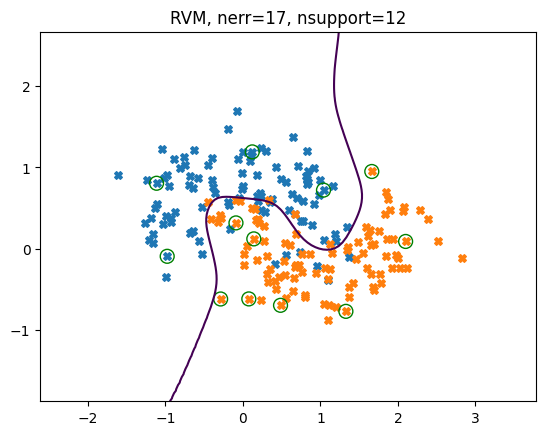

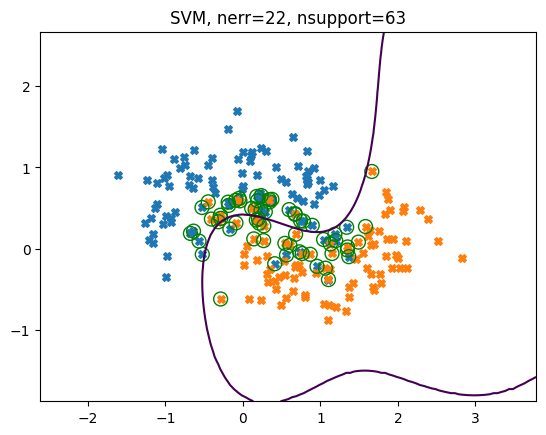


Model        nsupport   nerr   runtime(s)   accuracy
logregL2            4     25       0.3030     0.8750
logregL1           89     18       4.2700     0.9100
RVM                12     17       9.5310     0.9150
SVM                63     22       0.2793     0.8900


In [7]:
import time

levels = [0.5]
rbf_feature = RBFSampler(gamma=0.3, random_state=1, n_components=N)
X_rbf = rbf_feature.fit_transform(X)

results = {}

for (name, clf) in classifiers.items():
    start_time = time.time()

    if name == "logregL2":
        clf.fit(X_rbf, y)
        y_pred = clf.predict(X_rbf)
        Z = clf.predict_proba(rbf_feature.fit_transform(np.c_[xx.ravel(), yy.ravel()]))
        Z = Z[:, 0].reshape(xx.shape)
        plt.title(name + ", nerr= {}".format(np.sum(y != clf.predict(X_rbf))))
        plt.contour(xx, yy, Z, levels)
        plot_scatters(X, y)
        plt.show()
        print()

    elif name == "logregL1":
        clf.fit(X_rbf, y)
        y_pred = clf.predict(X_rbf)
        Z = clf.predict_proba(rbf_feature.fit_transform(np.c_[xx.ravel(), yy.ravel()]))
        Z = Z[:, 0].reshape(xx.shape)
        plt.contour(xx, yy, Z, levels)
        plot_scatters(X, y)
        conf_scores = np.abs(clf.decision_function(X_rbf))
        SV = X[(conf_scores > conf_scores.mean())]
        nsupport = SV.shape[0]
        nerr = np.sum(y != clf.predict(X_rbf))
        plot_SVs(SV)
        plt.title(f"{name}, nerr={nerr}, nsupport={nsupport}")
        plt.show()
        print()

    elif name == "RVM":
        clf.fit(X, y)
        y_pred = clf.predict(X)
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contour(xx, yy, Z, levels)
        plot_scatters(X, y)
        SV = clf.relevance_vectors_
        plot_SVs(SV)
        nsupport = SV.shape[0]
        nerr = np.sum(y != clf.predict(X))
        plt.title(f"{name}, nerr={nerr}, nsupport={nsupport}")
        plt.show()
        print()

    elif name == "SVM":
        clf.fit(X, y)
        y_pred = clf.predict(X)
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
        Z = Z[:, 0]
        Z = Z.reshape(xx.shape)
        plt.contour(xx, yy, Z, levels)
        plot_scatters(X, y)
        SV = clf.support_vectors_
        plot_SVs(SV)
        nsupport = SV.shape[0]
        nerr = np.sum(y != clf.predict(X))
        plt.title(f"{name}, nerr={nerr}, nsupport={nsupport}")
        plt.show()
        print()

    runtime = time.time() - start_time
    nerr = np.sum(y != y_pred)

    results[name] = {
        "nsupport": nsupport,
        "nerr": nerr,
        "runtime": runtime,
        "accuracy": np.mean(y_pred == y)
    }

print(f"{'Model':<10} {'nsupport':>10} {'nerr':>6} {'runtime(s)':>12} {'accuracy':>10}")
for name, metrics in results.items():
    print(f"{name:<10} {metrics['nsupport']:>10} {metrics['nerr']:>6} {metrics['runtime']:>12.4f} {metrics['accuracy']:>10.4f}")

### Analysis

1. Discuss the relative sparsity of the number of training points used by each method. Which method is most efficient at runtime?

2. How does your RVC model's performance compare to the other three models?

The RVM model is very sparse, using only 12 relevance vectors compared to 63 support vectors for SVM and 89 high-confidence points for L1 logistic regression. Despite this sparsity, RVM achieves the highest accuracy (91.5%) and the fewest errors, showing that it efficiently captures the decision boundary.

In terms of runtime, RVM is the slowest to train due to its iterative alpha updates, while SVM and L2 logistic regression are fastest. Overall, RVM offers an excellent tradeoff: high accuracy with minimal training points, though at the cost of longer computation time.

